In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

# for drawing map
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import read_orders, read_customers, read_geojson, plot_changes, plot_performance

In [2]:
orders = read_orders()

In [3]:
customers = read_customers()

<Axes: >

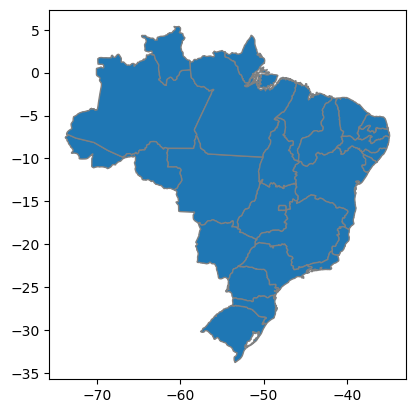

In [4]:
brasil = read_geojson('Brasil')
brasil.plot(edgecolor = "gray")

In [5]:
df = pd.merge(orders, customers, on='customer_id', how="inner")
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,total_delivery_time,estimated_delivery_time,wait_approve_time,seller_to_logistic_time,logistic_to_customer_time,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8 days 10:28:40,15 days 13:03:27,0 days 00:10:42,2 days 08:47:45,6 days 01:30:13,7c396fd4830fd04220f754e42b4e5bff,03149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,13 days 18:46:08,19 days 03:18:23,1 days 06:42:50,0 days 11:06:33,12 days 00:56:45,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,9 days 09:27:40,26 days 15:21:11,0 days 00:16:34,0 days 04:54:37,9 days 04:16:29,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,13 days 05:00:36,26 days 04:31:54,0 days 00:17:53,3 days 17:54:00,9 days 10:48:43,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2 days 20:58:23,12 days 02:41:21,0 days 01:01:50,0 days 21:26:05,1 days 22:30:28,72632f0f9dd73dfee390c9b22eb56dd6,09195,santo andre,SP


In [6]:
print(df.shape)
df = df[df['order_status'] == 'delivered']
df = df[df['total_delivery_time'].notnull()]
print(df.shape)

(99441, 17)
(96470, 17)


In [7]:
df['total_hours'] = df['total_delivery_time'].dt.total_seconds() / 3600.0
df['year'] = df['order_purchase_timestamp'].dt.year

In [9]:
def draw_boxplot(x, y, df):
# Create a box plot grouping data by day of the week
    fig, ax = plt.subplots(figsize=(10, 6)) #

    sns.boxplot(x=x, y=y, data=df, ax = ax)
    plt.show()

### Outliers

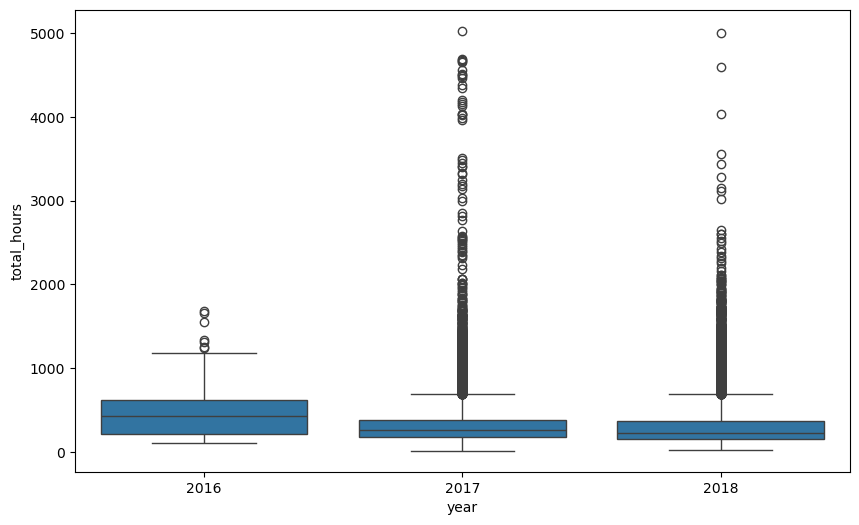

In [12]:
# Create a box plot grouping data by day of the week
draw_boxplot('year', 'total_hours', df)

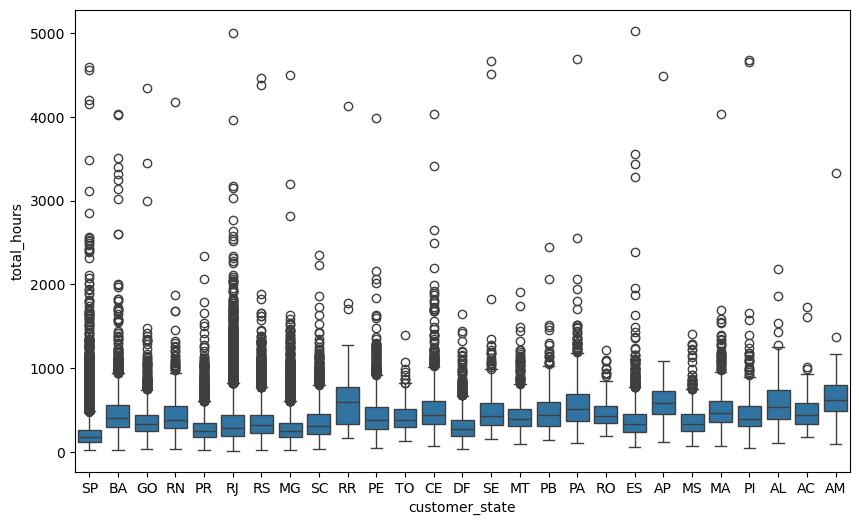

In [13]:
draw_boxplot('customer_state', 'total_hours', df)

In [14]:
def remove_outliers_iqr(df: pd.DataFrame, column: str, state: str) -> pd.DataFrame:
    """
    Removes outliers from a dataframe based on the IQR method.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter the DataFrame
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    # Log how many rows were removed
    outliers_count = len(df) - len(filtered_df)
    print(f"Removed {outliers_count} outliers from '{state}:{upper_bound}'")
    
    return filtered_df

In [15]:
states = df['customer_state'].value_counts().index
clean_df = pd.DataFrame()
for state in states:
    new_df = remove_outliers_iqr(df[df['customer_state'] == state], 'total_hours', state)
    clean_df = pd.concat([clean_df, new_df], ignore_index=True)

clean_df.shape

Removed 1972 outliers from 'SP:482.6363541666667'
Removed 868 outliers from 'RJ:816.1897569444443'
Removed 518 outliers from 'MG:606.8493402777776'
Removed 285 outliers from 'RS:772.5644097222223'
Removed 225 outliers from 'PR:605.72375'
Removed 135 outliers from 'SC:802.0869444444445'
Removed 132 outliers from 'BA:941.9572569444443'
Removed 73 outliers from 'DF:673.2260763888888'
Removed 88 outliers from 'ES:776.8345138888888'
Removed 81 outliers from 'GO:739.5738888888889'
Removed 94 outliers from 'PE:914.3447222222221'
Removed 77 outliers from 'CE:1015.7700694444445'
Removed 36 outliers from 'PA:1187.8311805555554'
Removed 44 outliers from 'MT:810.9971527777777'
Removed 39 outliers from 'MA:972.9731944444445'
Removed 33 outliers from 'MS:745.9818055555556'
Removed 18 outliers from 'PB:1030.1522222222222'
Removed 24 outliers from 'PI:911.009236111111'
Removed 30 outliers from 'RN:946.820347222222'
Removed 5 outliers from 'AL:1259.5329166666668'
Removed 20 outliers from 'SE:989.386874

(91643, 19)

### Delivery Time 2017 vs 2018

In [27]:
gp = clean_df.groupby(["customer_state", 'year'])['total_delivery_time'].median().reset_index()
gp = gp.pivot(index='customer_state', columns='year', values='total_delivery_time')

In [28]:
gp = gp.reset_index()
gp.columns

Index(['customer_state', 2016, 2017, 2018], dtype='object', name='year')

In [29]:
gp['17 vs 18'] = gp[2017] - gp[2018]
gp['17 vs 18'] = gp['17 vs 18'] .dt.total_seconds() / 3600.0

In [30]:
gdf = pd.merge(brasil[["UF", "geometry"]], gp, left_on='UF', right_on='customer_state', how='inner')


# Create a copy of the geometry using EPSG:3857 
geometry_3857 = gdf.geometry.to_crs(epsg = 3857)

# Find the center point for Markers/PopUps
gdf['center'] = geometry_3857.centroid.to_crs(epsg = 4236)

gdf.head()

,UF,geometry,customer_state,2016,2017,2018,17 vs 18,center
0,AC,"POLYGON ((-68.61895 -11.12971, -68.68534 -11.1...",AC,NaT,18 days 08:00:25,17 days 06:06:33,25.897778,POINT (-70.44565 -9.33281)
1,AL,"POLYGON ((-36.43149 -10.44823, -36.47339 -10.4...",AL,33 days 01:32:38,22 days 16:52:24,21 days 08:02:02,32.839444,POINT (-36.61065 -9.50338)
2,AP,"MULTIPOLYGON (((-51.90932 -1.16579, -51.96526 ...",AP,NaT,23 days 01:16:06,27 days 03:09:06,-97.883333,POINT (-51.9383 1.44925)
3,AM,"POLYGON ((-63.47887 2.19845, -63.43955 2.09251...",AM,NaT,25 days 00:58:49,26 days 20:44:05,-43.754444,POINT (-64.66208 -4.2071)
4,BA,"MULTIPOLYGON (((-45.95923 -14.89726, -45.93537...",BA,22 days 20:33:35,16 days 14:09:20,16 days 04:42:52.500000,9.440972,POINT (-41.66166 -12.49308)


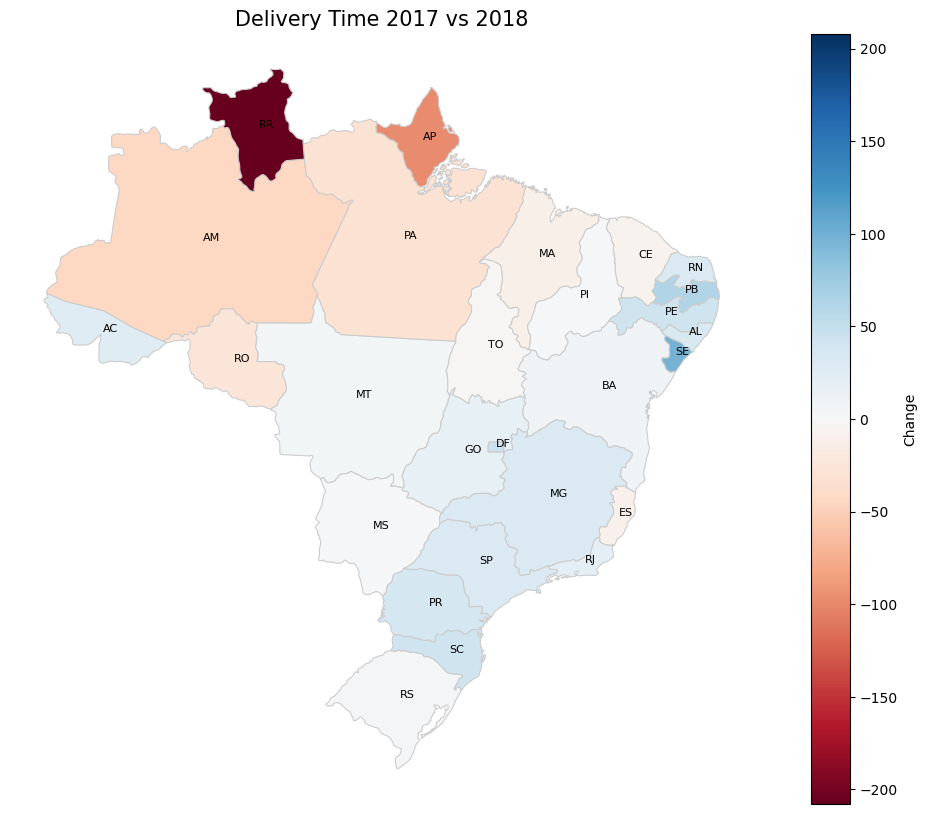

In [31]:
plot_changes(gdf, '17 vs 18', 'Delivery Time 2017 vs 2018')

In [21]:
gdf[gdf['UF'] == 'RR']

,UF,geometry,customer_state,2016,2017,2018,17 vs 18,center
22,RR,"POLYGON ((-63.47887 2.19845, -63.40024 2.27638...",RR,8 days 13:59:37,20 days 21:42:44.812500,25 days 22:18:55.047619047,-120.602843,POINT (-61.42321 2.11298)


### Delivery Time 2018

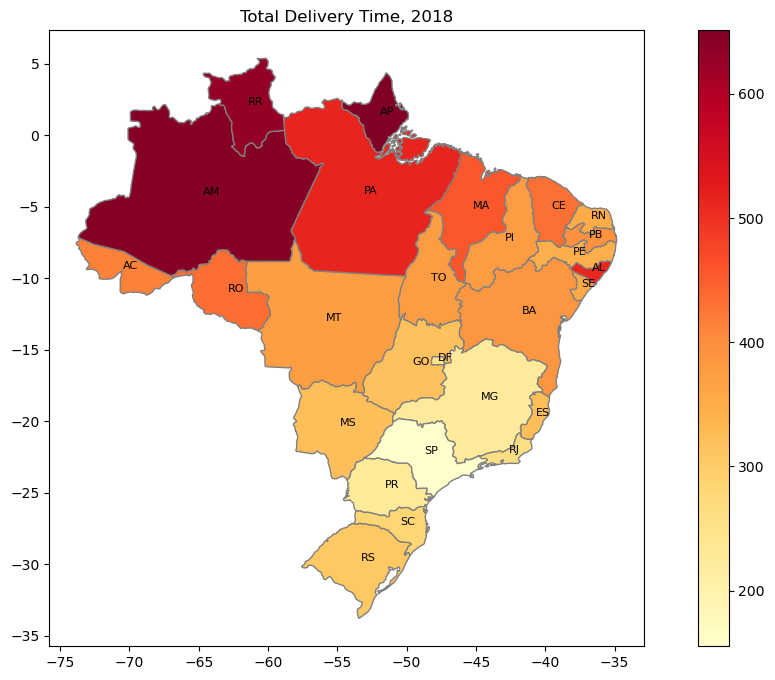

In [32]:
gdf['2018 total hours'] = gdf[2018].dt.total_seconds() / 3600.0
plot_performance(gdf, '2018 total hours', 'Total Delivery Time, 2018')

In [23]:
clean_df['total_days'] = clean_df['total_delivery_time'].dt.days

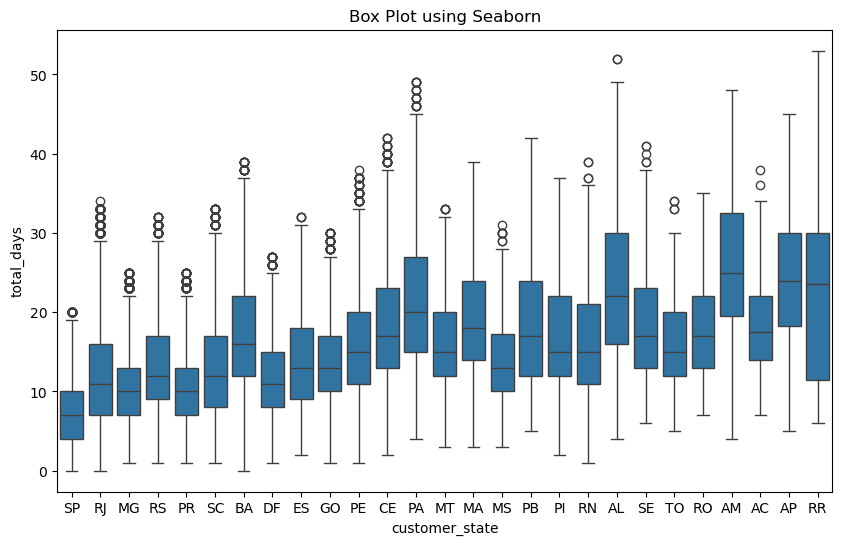

In [24]:
# Create a box plot grouping data by day of the week
fig, ax = plt.subplots(figsize=(10, 6)) #

sns.boxplot(x='customer_state', y='total_days', data=clean_df, ax = ax)
plt.title('Box Plot using Seaborn')
plt.show()

### Analyzing SP

In [53]:
sp = df[df['customer_state'] == 'SP']
sp_outliers = sp [sp['total_hours'] > 482.63].copy()
sp_outliers.shape

(1972, 19)

In [54]:
sp_outliers['year'].value_counts()

year
2018    1078
2017     859
2016      35
Name: count, dtype: int64

In [55]:
sp_outliers['total_day'] = sp_outliers['total_delivery_time'].dt.days
sp_outliers['estimated_day'] = sp_outliers['estimated_delivery_time'].dt.days
sp_outliers['wait_approve'] = sp_outliers['wait_approve_time'].dt.days
sp_outliers['seller_to_logistic'] = sp_outliers['seller_to_logistic_time'].dt.days
sp_outliers['logistic_to_customer'] = sp_outliers['logistic_to_customer_time'].dt.days


In [56]:
sp_outliers = sp_outliers[['order_id', 'customer_zip_code_prefix', 'customer_city', 'total_day', 'estimated_day', 'wait_approve', 'seller_to_logistic', 'logistic_to_customer']]
sp_outliers.head()

,order_id,customer_zip_code_prefix,customer_city,total_day,estimated_day,wait_approve,seller_to_logistic,logistic_to_customer
20,203096f03d82e0dffbc41ebc2e2bcfb7,04001,sao paulo,21,9,0,17.0,3.0
32,989225ba6d0ebd5873335f7e01de2ae7,05778,sao paulo,22,26,1,1.0,18.0
41,6ea2f835b4556291ffdc53fa0b3b95e8,19400,presidente venceslau,33,26,0,18.0,14.0
58,a685d016c8a26f71a0bb67821070e398,13068,campinas,23,16,0,8.0,14.0
152,1d067305b599c1e0dceb3864056ea527,14406,franca,23,22,0,6.0,17.0


In [57]:
sp_outliers.describe()

,total_day,estimated_day,wait_approve,seller_to_logistic,logistic_to_customer
count,1972.000000,1972.000000,1972.000000,1971.000000,1971.000000
mean,28.325051,24.200811,0.375254,8.633688,18.571284
std,13.479086,9.099274,0.968377,9.764421,14.996188
min,20.000000,4.000000,0.000000,-5.000000,0.000000
25%,21.000000,19.000000,0.000000,1.500000,10.000000
50%,24.000000,22.000000,0.000000,5.000000,18.000000
75%,30.000000,28.000000,0.000000,14.000000,22.000000
max,191.000000,96.000000,13.000000,107.000000,186.000000


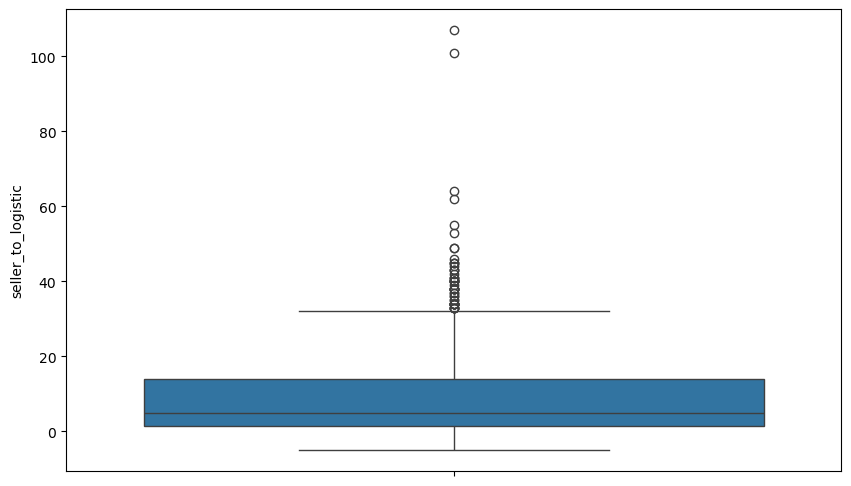

In [58]:
# Create a box plot grouping data by day of the week
fig, ax = plt.subplots(figsize=(10, 6)) #

sns.boxplot(y='seller_to_logistic', data=sp_outliers, ax = ax)
plt.show()

In [61]:
sp_outliers[sp_outliers['seller_to_logistic'] > 8].shape

(707, 8)

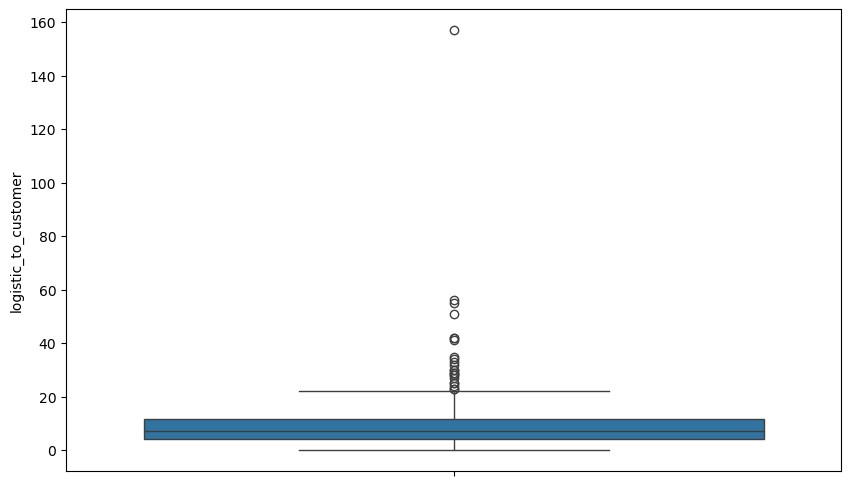

In [60]:
# Create a box plot grouping data by day of the week
fig, ax = plt.subplots(figsize=(10, 6)) #

sns.boxplot(y='logistic_to_customer', data=sp_outliers[sp_outliers['seller_to_logistic'] > 8], ax = ax)
plt.show()

<Axes: >

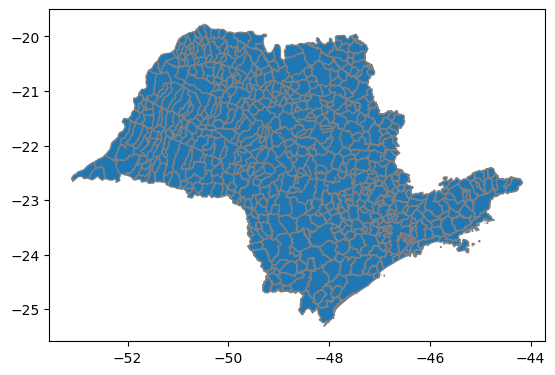

In [40]:
sp_geo = read_geojson('SP')
sp_geo.plot(edgecolor = "gray")

In [ ]:
gdf = pd.merge(sp_geo[["UF", "geometry"]], sp_outliers, left_on='UF', right_on='customer_state', how='inner')